# 03 - Sequence Similarity Analysis

**Goal:** Calculate pairwise sequence similarities to understand the relationship between sequence alignment and functional similarity.

**Research Question:** What is the relationship between sequence alignment percentage and functional similarity?

---

## Overview

In this phase, we will:
1. Load Phase 2 results (sequences with labels)
2. Calculate sequence identity for unlabeled sequences
3. Find closest matching labeled sequence for each unlabeled sequence
4. Analyze similarity distribution
5. Save results for Phase 4

**Input:** `sequences_labeled_classification.csv` (from Phase 2)

**Output:** 
- `phase3_similarity_results.csv`
- `phase3_summary_stats.csv`
- `phase3_all_sequences_with_similarity.csv`

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Phase 2 Results

In [3]:
# Load your Phase 2 labeled data
df = pd.read_csv('../data/processed/sequences_labeled_classification.csv')

print(f"Loaded {len(df)} sequences from Phase 2")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Loaded 1908 sequences from Phase 2

Columns: ['id', 'uniref_id', 'full_header', 'sequence', 'length', 'gap_count', 'gap_percentage', 'has_DRY', 'has_NPxxY', 'uniprot_id', 'protein_name', 'gene_name', 'organism', 'query_status', 'subfamily']

First few rows:


,id,uniref_id,full_header,sequence,length,gap_count,gap_percentage,has_DRY,has_NPxxY,uniprot_id,protein_name,gene_name,organism,query_status,subfamily
0,P07550,P07550,P07550,MGQPGNGSAFLLAPNGSHAPDHDVTQERDEVWVVGMGIVMSLIVLA...,413,0,0.0,True,True,P07550,Beta-2 adrenergic receptor,ADRB2,Homo sapiens,success,Adrenergic_beta
1,UniRef100_A0A8D2HM49,A0A8D2HM49,UniRef100_A0A8D2HM49\t434\t0.920\t2.021E-131\t...,MGQPGNSSDFLLASNGSHAPDHNVTQERDEAWVVGMAIVMSLIVLA...,416,0,0.0,True,True,A0A8D2HM49,Beta-2 adrenergic receptor,ADRB2,Urocitellus parryii,success,Adrenergic_beta
2,UniRef100_A0A250YHJ2,A0A250YHJ2,UniRef100_A0A250YHJ2\t430\t0.889\t4.668E-130\t...,MGQPGNDSDFLLAPNGSQAPGHDITQERDEAWVVGMAMVMSLIVLA...,418,0,0.0,True,True,A0A250YHJ2,Beta-2 adrenergic receptor,ADRB2,Castor canadensis,success,Adrenergic_beta
3,UniRef100_UPI0000E2F3F2,UPI0000E2F3F2,UniRef100_UPI0000E2F3F2\t427\t0.902\t5.752E-12...,MGQPGNGSDFLLAPNGSHAPDHDISQETDEAWVVGLAIVMSLIVLA...,420,0,0.0,True,True,UPI0000E2F3F2,Error,Error,Error,timeout,Other_ClassA
4,UniRef100_UPI00189D415B,UPI00189D415B,UniRef100_UPI00189D415B\t426\t0.894\t7.873E-12...,MGQPGNNSVFLLAPNGSHEPDHNVTQERDEAWVVGMGIVMSFIVLA...,418,0,0.0,True,True,UPI00189D415B,Error,Error,Error,timeout,Other_ClassA


In [4]:
# Check current classification status
print("Current subfamily distribution:")
print(df['subfamily'].value_counts())

print("\nQuery status distribution:")
print(df['query_status'].value_counts())

Current subfamily distribution:
subfamily
Other_ClassA        1483
Adrenergic_beta      372
Adrenergic_alpha      53
Name: count, dtype: int64

Query status distribution:
query_status
success    1000
timeout     908
Name: count, dtype: int64


In [5]:
# Separate labeled from unlabeled sequences
# Labeled = sequences with confirmed functional annotations
labeled = df[df['subfamily'].isin(['Adrenergic_beta', 'Adrenergic_alpha'])].copy()

# Unlabeled = sequences that need classification
unlabeled = df[df['subfamily'] == 'Other_ClassA'].copy()

print(f"Labeled sequences (known function): {len(labeled)}")
print(f"  - Adrenergic_beta:  {(labeled['subfamily'] == 'Adrenergic_beta').sum()}")
print(f"  - Adrenergic_alpha: {(labeled['subfamily'] == 'Adrenergic_alpha').sum()}")
print(f"\nUnlabeled sequences (need classification): {len(unlabeled)}")
print(f"  - With UniProt success: {(unlabeled['query_status'] == 'success').sum()}")
print(f"  - With timeout/error:   {(unlabeled['query_status'] == 'timeout').sum()}")

Labeled sequences (known function): 425
  - Adrenergic_beta:  372
  - Adrenergic_alpha: 53

Unlabeled sequences (need classification): 1483
  - With UniProt success: 575
  - With timeout/error:   908


## 3. Define Sequence Similarity Function

We'll calculate **percentage identity** between sequences. This gives us the "alignment %" for our research question.

In [6]:
def calculate_sequence_identity(seq1, seq2):
    """
    Calculate percentage identity between two sequences.
    
    Parameters:
    -----------
    seq1, seq2 : str
        Amino acid sequences (may contain gaps '-')
    
    Returns:
    --------
    float : Percentage identity (0-100)
    
    Method:
    -------
    Identity = (Number of matching residues / Total aligned positions) × 100
    Gaps are ignored in the calculation.
    """
    # Make sequences same length by padding with gaps
    max_len = max(len(seq1), len(seq2))
    seq1 = seq1.ljust(max_len, '-')
    seq2 = seq2.ljust(max_len, '-')
    
    matches = 0
    valid_positions = 0
    
    # Count matches, skipping positions with gaps
    for aa1, aa2 in zip(seq1, seq2):
        if aa1 != '-' and aa2 != '-':  # Valid aligned position
            valid_positions += 1
            if aa1 == aa2:  # Matching residue
                matches += 1
    
    if valid_positions == 0:
        return 0.0
    
    return 100.0 * matches / valid_positions

print("✓ Sequence identity function defined")

✓ Sequence identity function defined


In [7]:
# Test the function with two known beta-adrenergic receptors
test_seq1 = labeled.iloc[0]['sequence']
test_seq2 = labeled.iloc[1]['sequence']
test_identity = calculate_sequence_identity(test_seq1, test_seq2)

print("Testing sequence identity function:")
print(f"  Sequence 1: {labeled.iloc[0]['uniprot_id']} ({labeled.iloc[0]['subfamily']})")
print(f"  Sequence 2: {labeled.iloc[1]['uniprot_id']} ({labeled.iloc[1]['subfamily']})")
print(f"  Identity: {test_identity:.2f}%")
print(f"\n✓ Function working correctly!")
print(f"  Both are {labeled.iloc[0]['subfamily']} and show {test_identity:.1f}% identity")

Testing sequence identity function:
  Sequence 1: P07550 (Adrenergic_beta)
  Sequence 2: A0A8D2HM49 (Adrenergic_beta)
  Identity: 82.57%

✓ Function working correctly!
  Both are Adrenergic_beta and show 82.6% identity


## 4. Calculate Similarities for All Unlabeled Sequences

For each unlabeled sequence, we'll:
1. Compare it to ALL labeled sequences
2. Find the most similar labeled sequence
3. Record the maximum identity percentage

**Note:** This will take 2-3 minutes for ~1500 sequences × 425 comparisons.

In [8]:
# Calculate total number of comparisons
total_comparisons = len(unlabeled) * len(labeled)

print("="*80)
print("SEQUENCE SIMILARITY CALCULATION")
print("="*80)
print(f"\nUnlabeled sequences to analyze: {len(unlabeled):,}")
print(f"Labeled reference sequences: {len(labeled):,}")
print(f"Total comparisons: {total_comparisons:,}")
print(f"\nEstimated time: 2-3 minutes")
print(f"\nStarting calculation...")

SEQUENCE SIMILARITY CALCULATION

Unlabeled sequences to analyze: 1,483
Labeled reference sequences: 425
Total comparisons: 630,275

Estimated time: 2-3 minutes

Starting calculation...


In [9]:
# Initialize results list
results = []
start_time = time.time()

# Process each unlabeled sequence
for idx, row_unlabeled in tqdm(unlabeled.iterrows(), total=len(unlabeled), desc="Processing sequences"):
    
    seq_unlabeled = row_unlabeled['sequence']
    
    # Find the most similar labeled sequence
    max_identity = 0
    best_match_id = None
    best_match_subfamily = None
    best_match_name = None
    
    # Compare against all labeled sequences
    for _, row_labeled in labeled.iterrows():
        seq_labeled = row_labeled['sequence']
        identity = calculate_sequence_identity(seq_unlabeled, seq_labeled)
        
        if identity > max_identity:
            max_identity = identity
            best_match_id = row_labeled['uniprot_id']
            best_match_subfamily = row_labeled['subfamily']
            best_match_name = row_labeled['protein_name']
    
    # Store results
    results.append({
        'uniprot_id': row_unlabeled['uniprot_id'],
        'uniref_id': row_unlabeled['uniref_id'],
        'sequence': row_unlabeled['sequence'],
        'length': row_unlabeled['length'],
        'has_DRY': row_unlabeled['has_DRY'],
        'has_NPxxY': row_unlabeled['has_NPxxY'],
        'original_subfamily': row_unlabeled['subfamily'],
        'original_protein_name': row_unlabeled['protein_name'],
        'organism': row_unlabeled['organism'],
        'query_status': row_unlabeled['query_status'],
        'closest_match_id': best_match_id,
        'closest_match_subfamily': best_match_subfamily,
        'closest_match_name': best_match_name,
        'max_identity_percent': max_identity
    })

elapsed_time = time.time() - start_time
print(f"\n✓ Completed in {elapsed_time:.1f} seconds ({elapsed_time/60:.2f} minutes)")

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(f"✓ Processed {len(results_df)} sequences")

Processing sequences:   0%|          | 0/1483 [00:00<?, ?it/s]


✓ Completed in 127.1 seconds (2.12 minutes)
✓ Processed 1483 sequences


## 5. Analyze Similarity Results

In [10]:
# Summary statistics
print("SEQUENCE IDENTITY STATISTICS")
print("="*80)
print(f"Mean:     {results_df['max_identity_percent'].mean():.2f}%")
print(f"Median:   {results_df['max_identity_percent'].median():.2f}%")
print(f"Std Dev:  {results_df['max_identity_percent'].std():.2f}%")
print(f"Min:      {results_df['max_identity_percent'].min():.2f}%")
print(f"Max:      {results_df['max_identity_percent'].max():.2f}%")

# Show distribution
results_df['max_identity_percent'].describe()

SEQUENCE IDENTITY STATISTICS
Mean:     42.66%
Median:   33.46%
Std Dev:  22.78%
Min:      8.61%
Max:      100.00%


count    1483.000000
mean       42.657136
std        22.780176
min         8.611111
25%        26.677820
50%        33.464567
75%        55.796334
max       100.000000
Name: max_identity_percent, dtype: float64

In [11]:
# Identity distribution by ranges
print("\nIDENTITY DISTRIBUTION (Alignment %)")
print("="*80)

ranges = [
    ('>95%', results_df['max_identity_percent'] > 95),
    ('90-95%', (results_df['max_identity_percent'] >= 90) & (results_df['max_identity_percent'] <= 95)),
    ('85-90%', (results_df['max_identity_percent'] >= 85) & (results_df['max_identity_percent'] < 90)),
    ('70-85%', (results_df['max_identity_percent'] >= 70) & (results_df['max_identity_percent'] < 85)),
    ('50-70%', (results_df['max_identity_percent'] >= 50) & (results_df['max_identity_percent'] < 70)),
    ('<50%', results_df['max_identity_percent'] < 50)
]

for range_name, mask in ranges:
    count = mask.sum()
    pct = 100 * count / len(results_df)
    print(f"{range_name:10s}: {count:4d} sequences ({pct:5.1f}%)")


IDENTITY DISTRIBUTION (Alignment %)
>95%      :   29 sequences (  2.0%)
90-95%    :   73 sequences (  4.9%)
85-90%    :   39 sequences (  2.6%)
70-85%    :  103 sequences (  6.9%)
50-70%    :  174 sequences ( 11.7%)
<50%      : 1065 sequences ( 71.8%)


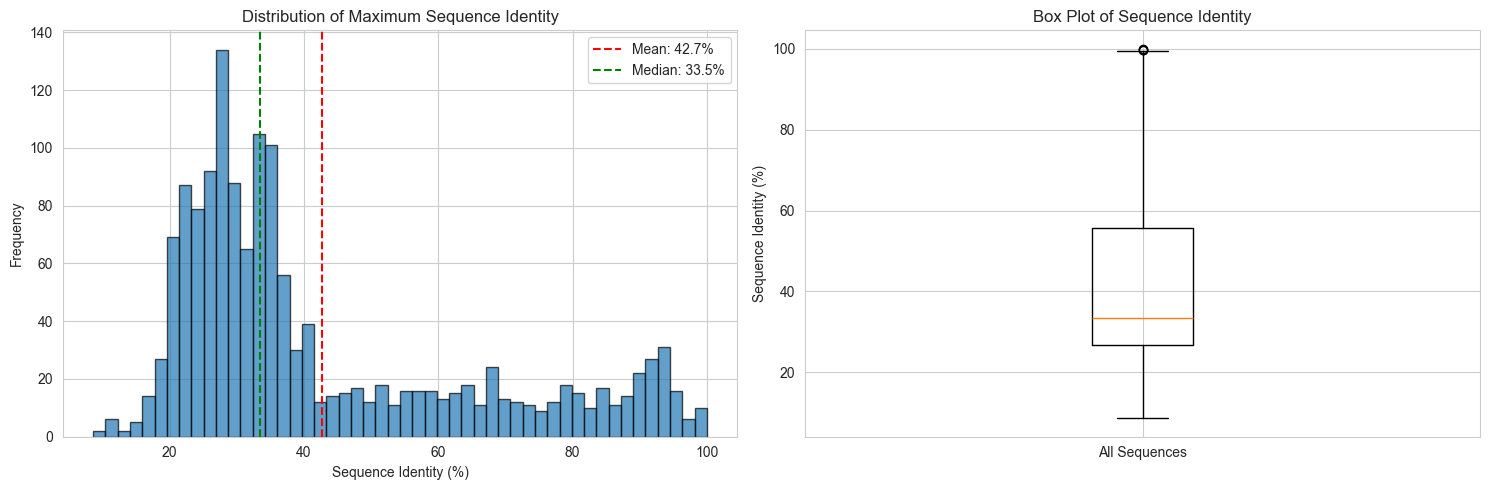

✓ Saved plot: identity_distribution.png


In [14]:
# Visualize identity distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(results_df['max_identity_percent'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sequence Identity (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Maximum Sequence Identity')
axes[0].axvline(results_df['max_identity_percent'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["max_identity_percent"].mean():.1f}%')
axes[0].axvline(results_df['max_identity_percent'].median(), color='green', linestyle='--', label=f'Median: {results_df["max_identity_percent"].median():.1f}%')
axes[0].legend()

# Box plot
axes[1].boxplot(results_df['max_identity_percent'], vert=True)
axes[1].set_ylabel('Sequence Identity (%)')
axes[1].set_title('Box Plot of Sequence Identity')
axes[1].set_xticklabels(['All Sequences'])

plt.tight_layout()
plt.savefig('../results/figures/identity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved plot: identity_distribution.png")

In [15]:
# Predicted subfamilies based on closest match
print("\nPREDICTED SUBFAMILIES (based on closest match)")
print("="*80)
print(results_df['closest_match_subfamily'].value_counts())


PREDICTED SUBFAMILIES (based on closest match)
closest_match_subfamily
Adrenergic_beta     1275
Adrenergic_alpha     208
Name: count, dtype: int64


In [16]:
# Compare timeout vs success sequences
print("\nCOMPARISON: UniProt Query Status vs Sequence Identity")
print("="*80)

for status in ['success', 'timeout']:
    subset = results_df[results_df['query_status'] == status]
    if len(subset) > 0:
        print(f"\n{status.upper()}:")
        print(f"  Count: {len(subset)}")
        print(f"  Mean identity: {subset['max_identity_percent'].mean():.2f}%")
        print(f"  Median identity: {subset['max_identity_percent'].median():.2f}%")


COMPARISON: UniProt Query Status vs Sequence Identity

SUCCESS:
  Count: 575
  Mean identity: 35.60%
  Median identity: 30.46%

TIMEOUT:
  Count: 908
  Mean identity: 47.12%
  Median identity: 35.94%


## 6. Explore Cases for Research Question

Finding examples for: **"Does high alignment = same function?"**

In [17]:
# Case 1: High alignment (>90%)
high_align = results_df[results_df['max_identity_percent'] > 90].sort_values('max_identity_percent', ascending=False)

print("CASE 1: High Alignment (>90%)")
print("="*80)
print(f"Found {len(high_align)} sequences with >90% identity\n")
print("Top 10 examples:")
display_cols = ['uniprot_id', 'max_identity_percent', 'closest_match_subfamily', 'original_protein_name', 'query_status']
high_align[display_cols].head(10)

CASE 1: High Alignment (>90%)
Found 101 sequences with >90% identity

Top 10 examples:


,uniprot_id,max_identity_percent,closest_match_subfamily,original_protein_name,query_status
37,UPI0018F401A4,100.000000,Adrenergic_beta,Error,timeout
15,UPI001877061C,99.635036,Adrenergic_beta,Error,timeout
7,UPI000B4EE61A,99.601594,Adrenergic_beta,Error,timeout
100,UPI0004F469D1,99.397590,Adrenergic_beta,Error,timeout
50,UPI0005326717,99.348534,Adrenergic_beta,Error,timeout
206,UPI0005306AF5,99.245283,Adrenergic_beta,Error,timeout
29,UPI0012B504DC,99.041534,Adrenergic_beta,Error,timeout
11,UPI001B34845D,98.913043,Adrenergic_beta,Error,timeout
91,UPI000FFCBA2F,98.293515,Adrenergic_beta,Error,timeout
127,UPI00155E54FC,98.176292,Adrenergic_beta,Error,timeout


In [18]:
# Case 2: Moderate alignment (70-85%) - MOST INTERESTING FOR RESEARCH!
mod_align = results_df[
    (results_df['max_identity_percent'] >= 70) & 
    (results_df['max_identity_percent'] <= 85)
].sort_values('max_identity_percent', ascending=False)

print("CASE 2: Moderate Alignment (70-85%) - KEY FOR RESEARCH QUESTION")
print("="*80)
print(f"Found {len(mod_align)} sequences with 70-85% identity\n")

# Check how many have protein names
mod_with_names = mod_align[mod_align['query_status'] == 'success']
print(f"{len(mod_with_names)} have UniProt annotations (can check if different function!)\n")

print("Top 10 examples:")
mod_align[display_cols].head(10)

CASE 2: Moderate Alignment (70-85%) - KEY FOR RESEARCH QUESTION
Found 103 sequences with 70-85% identity

24 have UniProt annotations (can check if different function!)

Top 10 examples:


,uniprot_id,max_identity_percent,closest_match_subfamily,original_protein_name,query_status
405,UPI001470EB70,84.905660,Adrenergic_alpha,Error,timeout
52,UPI000441FCAB,84.750733,Adrenergic_beta,Error,timeout
221,UPI001C08F8EE,84.668990,Adrenergic_beta,Error,timeout
28,UPI0023028A11,84.657534,Adrenergic_beta,Error,timeout
227,UPI00201926D8,84.419263,Adrenergic_beta,Error,timeout
155,UPI0020B29655,84.313725,Adrenergic_beta,Error,timeout
213,UPI00188F97B6,84.117647,Adrenergic_beta,Error,timeout
69,UPI00235ACC3E,83.841463,Adrenergic_beta,Error,timeout
273,UPI0023057D8C,83.841463,Adrenergic_beta,Error,timeout
365,UPI000A336C60,83.823529,Adrenergic_beta,Error,timeout


In [19]:
# Case 3: Low alignment (<50%) - Different GPCRs?
low_align = results_df[results_df['max_identity_percent'] < 50].sort_values('max_identity_percent', ascending=False)

print("CASE 3: Low Alignment (<50%) - Likely Different GPCR Types")
print("="*80)
print(f"Found {len(low_align)} sequences with <50% identity\n")

# Check protein names for these
low_with_names = low_align[low_align['query_status'] == 'success']
print(f"{len(low_with_names)} have UniProt annotations\n")

if len(low_with_names) > 0:
    print("Common protein names in low similarity group:")
    name_counts = low_with_names['original_protein_name'].value_counts().head(10)
    for name, count in name_counts.items():
        if name != 'Unknown':
            print(f"  {count:3d}x {name[:60]}")

print("\nTop 10 examples (highest of the low):")
low_align[display_cols].head(10)

CASE 3: Low Alignment (<50%) - Likely Different GPCR Types
Found 1065 sequences with <50% identity

482 have UniProt annotations

Common protein names in low similarity group:
  153x G-protein coupled receptors family 1 profile domain-containi
   13x 5-hydroxytryptamine receptor 4
   10x Trace amine-associated receptor 1
   10x Octopamine receptor beta-2R
    5x 5-hydroxytryptamine receptor 6
    2x 5-hydroxytryptamine receptor 1D
    2x Substance-K receptor
    1x Probable G-protein coupled receptor No18
    1x Somatostatin receptor type 2

Top 10 examples (highest of the low):


,uniprot_id,max_identity_percent,closest_match_subfamily,original_protein_name,query_status
813,UPI001C3FBA14,49.710983,Adrenergic_alpha,Error,timeout
635,UPI00234D6083,49.567723,Adrenergic_alpha,Error,timeout
701,UPI001B7EA9AB,49.557522,Adrenergic_alpha,Error,timeout
335,UPI0007425C32,49.532710,Adrenergic_beta,Error,timeout
406,UPI00057640EE,49.318801,Adrenergic_alpha,Error,timeout
691,UPI001BE00C84,48.854962,Adrenergic_beta,Error,timeout
421,UPI000CD64D02,48.550725,Adrenergic_beta,Error,timeout
646,UPI00094F375C,48.501362,Adrenergic_alpha,Error,timeout
719,A0A8C4QW85,48.417722,Adrenergic_alpha,Unknown,success
792,A0A8C4QHV2,48.387097,Adrenergic_beta,G-protein coupled receptors family 1 profile d...,success


## 7. Save Results

In [22]:
# Save similarity results for unlabeled sequences
output_file = '../data/processed/similarity_results.csv'
results_df.to_csv(output_file, index=False)
print(f"✓ Saved: {output_file}")
print(f"  Contains {len(results_df)} unlabeled sequences with similarity scores")

✓ Saved: ../data/processed/similarity_results.csv
  Contains 1483 unlabeled sequences with similarity scores


In [24]:
# Save summary statistics
summary_stats = {
    'total_sequences_analyzed': len(results_df),
    'mean_identity': results_df['max_identity_percent'].mean(),
    'median_identity': results_df['max_identity_percent'].median(),
    'std_identity': results_df['max_identity_percent'].std(),
    'min_identity': results_df['max_identity_percent'].min(),
    'max_identity': results_df['max_identity_percent'].max(),
    'very_high_similarity_95plus': (results_df['max_identity_percent'] > 95).sum(),
    'high_similarity_85to95': ((results_df['max_identity_percent'] >= 85) & 
                                (results_df['max_identity_percent'] <= 95)).sum(),
    'moderate_similarity_70to85': ((results_df['max_identity_percent'] >= 70) & 
                                    (results_df['max_identity_percent'] < 85)).sum(),
    'low_similarity_50to70': ((results_df['max_identity_percent'] >= 50) & 
                              (results_df['max_identity_percent'] < 70)).sum(),
    'very_low_similarity_below50': (results_df['max_identity_percent'] < 50).sum()
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv('../data/processed/phase3_summary_stats.csv', index=False)
print(f"✓ Saved: phase3_summary_stats.csv")

✓ Saved: phase3_summary_stats.csv


In [25]:
# Create combined dataset with ALL sequences for Phase 4
print("\nCreating combined dataset...")

# Add similarity info to labeled sequences (they're 100% identical to themselves)
labeled_with_similarity = labeled.copy()
labeled_with_similarity['max_identity_percent'] = 100.0
labeled_with_similarity['closest_match_id'] = labeled_with_similarity['uniprot_id']
labeled_with_similarity['closest_match_subfamily'] = labeled_with_similarity['subfamily']
labeled_with_similarity['closest_match_name'] = labeled_with_similarity['protein_name']

# Combine labeled and unlabeled
all_sequences = pd.concat([labeled_with_similarity, results_df], ignore_index=True)

print(f"Combined dataset: {len(all_sequences)} sequences")
print(f"  - Originally labeled: {len(labeled)}")
print(f"  - Unlabeled with similarity: {len(results_df)}")

# Save combined dataset
combined_file = '../data/processed/phase3_all_sequences_with_similarity.csv'
all_sequences.to_csv(combined_file, index=False)
print(f"✓ Saved: {combined_file}")


Creating combined dataset...
Combined dataset: 1908 sequences
  - Originally labeled: 425
  - Unlabeled with similarity: 1483
✓ Saved: ../data/processed/phase3_all_sequences_with_similarity.csv


## 8. Summary & Next Steps

In [26]:
print("="*80)
print("PHASE 3 COMPLETE!")
print("="*80)

print("\n📁 Files Created:")
print("  1. phase3_similarity_results.csv - Similarity scores for unlabeled sequences")
print("  2. phase3_summary_stats.csv - Summary statistics")
print("  3. phase3_all_sequences_with_similarity.csv - Complete dataset for Phase 4")
print("  4. phase3_identity_distribution.png - Visualization")

print("\n📊 Key Findings:")
print(f"  • Analyzed {len(results_df)} unlabeled sequences")
print(f"  • Mean identity: {results_df['max_identity_percent'].mean():.1f}%")
print(f"  • High similarity (>90%): {(results_df['max_identity_percent'] > 90).sum()} sequences")
print(f"  • Moderate similarity (70-85%): {((results_df['max_identity_percent'] >= 70) & (results_df['max_identity_percent'] < 85)).sum()} sequences")
print(f"  • Low similarity (<50%): {(results_df['max_identity_percent'] < 50).sum()} sequences")

print("\n🎯 Ready for Phase 4:")
print("  • Classify all sequences into 4-5 functional categories")
print("  • Use similarity thresholds + protein names + sequence features")
print("  • Prepare for alignment vs function analysis (Phase 5)")

print("\n✅ Phase 3 Complete!")

PHASE 3 COMPLETE!

📁 Files Created:
  1. phase3_similarity_results.csv - Similarity scores for unlabeled sequences
  2. phase3_summary_stats.csv - Summary statistics
  3. phase3_all_sequences_with_similarity.csv - Complete dataset for Phase 4
  4. phase3_identity_distribution.png - Visualization

📊 Key Findings:
  • Analyzed 1483 unlabeled sequences
  • Mean identity: 42.7%
  • High similarity (>90%): 101 sequences
  • Moderate similarity (70-85%): 103 sequences
  • Low similarity (<50%): 1065 sequences

🎯 Ready for Phase 4:
  • Classify all sequences into 4-5 functional categories
  • Use similarity thresholds + protein names + sequence features
  • Prepare for alignment vs function analysis (Phase 5)

✅ Phase 3 Complete!
